In [3]:
import os
import numpy as np
import scipy as sp
from scipy.linalg import expm
import pandas as pandas
import matplotlib.pyplot as plt
from scipy.integrate import odeint, ODEintWarning
from scipy.optimize import minimize
from Nexis_human_functions import heatmap, normalize_by_l2_norm, mse_matrix, Nexis_error
from functools import partial
from scipy.stats import pearsonr
from Nexis_human_model import run_Nexis
import csv
import warnings
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

## Preparing Inputs

In [4]:
# Prepare connectivity matrix

# Load connectivity matrix
connectivity_df = pandas.read_csv('/Users/robinsandell/Desktop/Raj Lab/Human Nexis/CODE Nexis Human/input data/Connectivity matrix original.csv')

# List of striatal regions to exclude from further analysis CAN EDIT THIS
regions_to_exclude = ['Left-Pallidum','Right-Pallidum','Left-Accumbens-area','Right-Accumbens-area','Right-Putamen','Left-Putamen','Right-Caudate','Left-Caudate']

# Find indices (in the region order of the connectivity matrix) for regions to exclude 
excluded_indices = [connectivity_df.columns.get_loc(region) for region in regions_to_exclude]

# Delete striatal regions 
connectivity_df = connectivity_df.drop(index = excluded_indices)
connectivity_df = connectivity_df.drop(columns=regions_to_exclude)

# Convert connectivity matrix to a nROI x nROI array
connectivity_matrix = connectivity_df.values

# Normalize connectivity matrix 
max = np.max(connectivity_matrix)
connectivity_matrix = connectivity_matrix / max

# Define the number of regions  
nROI = 86 - len(regions_to_exclude)

In [68]:
# Initial vector

# SET INITIAL VECTOR METHOD ('baseline' or 'binary')
init_vec_method = 'baseline' 

# Conversion of ADNI region order to match connectivity matrix
new_order_ADNI = [68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]

# Order of regions (left subcortex, right subcortex, left cortex, right cortex)
regions = ['Left-Cerebellum-Cortex','Left-Thalamus-Proper','Left-Hippocampus','Left-Amygdala','Left-VentralDC','Right-Cerebellum-Cortex','Right-Thalamus-Proper','Right-Hippocampus','Right-Amygdala','Right-VentralDC','ctx-lh-bankssts','ctx-lh-caudalanteriorcingulate','ctx-lh-caudalmiddlefrontal','ctx-lh-cuneus','ctx-lh-entorhinal','ctx-lh-fusiform','ctx-lh-inferiorparietal','ctx-lh-inferiortemporal','ctx-lh-isthmuscingulate','ctx-lh-lateraloccipital','ctx-lh-lateralorbitofrontal','ctx-lh-lingual','ctx-lh-medialorbitofrontal','ctx-lh-middletemporal','ctx-lh-parahippocampal','ctx-lh-paracentral','ctx-lh-parsopercularis','ctx-lh-parsorbitalis','ctx-lh-parstriangularis','ctx-lh-pericalcarine','ctx-lh-postcentral','ctx-lh-posteriorcingulate','ctx-lh-precentral','ctx-lh-precuneus','ctx-lh-rostralanteriorcingulate','ctx-lh-rostralmiddlefrontal','ctx-lh-superiorfrontal','ctx-lh-superiorparietal','ctx-lh-superiortemporal','ctx-lh-supramarginal','ctx-lh-frontalpole','ctx-lh-temporalpole','ctx-lh-transversetemporal','ctx-lh-insula', 'ctx-rh-bankssts', 'ctx-rh-caudalanteriorcingulate', 'ctx-rh-caudalmiddlefrontal', 'ctx-rh-cuneus',	'ctx-rh-entorhinal', 'ctx-rh-fusiform','ctx-rh-inferiorparietal','ctx-rh-inferiortemporal',	'ctx-rh-isthmuscingulate','ctx-rh-lateraloccipital','ctx-rh-lateralorbitofrontal','ctx-rh-lingual','ctx-rh-medialorbitofrontal','ctx-rh-middletemporal','ctx-rh-parahippocampal','ctx-rh-paracentral','ctx-rh-parsopercularis','ctx-rh-parsorbitalis','ctx-rh-parstriangularis','ctx-rh-pericalcarine','ctx-rh-postcentral','ctx-rh-posteriorcingulate',	'ctx-rh-precentral',	'ctx-rh-precuneus','ctx-rh-rostralanteriorcingulate','ctx-rh-rostralmiddlefrontal','ctx-rh-superiorfrontal','ctx-rh-superiorparietal','ctx-rh-superiortemporal','ctx-rh-supramarginal','ctx-rh-frontalpole','ctx-rh-temporalpole','ctx-rh-transversetemporal','ctx-rh-insula']

# Use baseline data from EBM tau time series
if init_vec_method == 'baseline':

    init_con = pandas.read_csv('Regional tau time series .csv')

    # Housekeeping
    init_con = init_con.drop('Unnamed: 0',axis=1)

    # Reorder regions 
    init_con_reordered = init_con.iloc[:, new_order_ADNI]

    # Delete striatal regions 
    columns_to_delete = init_con_reordered.columns[excluded_indices]
    init_con_excluded = init_con_reordered.drop(columns_to_delete, axis = 1)

    # Take the first row (time point 0) as initial vector
    init_vec = init_con_excluded.iloc[0].values

    # Set use_baseline NEXIS input to 1 to indicate use of baseline data as initial vector  
    use_baseline_ = 1

# Binary vector indicating seeding location 
if init_vec_method == 'binary': 

    seeding_locations = ['ctx-lh-entorhinal', 'ctx-rh-entorhinal'] # MANUALLY EDIT SEEDING LOCATION HERE
    seeding_indices = [regions.index(item) for item in seeding_locations if item in seeding_locations]

    # Create a 1D array of zeros with length nROI
    array_length = nROI
    init_vec = np.zeros(array_length)

    # Set entries for seeding locations to 1 (both left and right hemisphere)
    init_vec[seeding_indices[0]] = 1 
    init_vec[seeding_indices[1]] = 1

    # Set use_baseline NEXIS input to 0 to indicate use of binary initial vector 
    use_baseline_ = 0 

In [69]:
# Load DK regional volumes 
regional_volumes = pandas.read_csv('DK_ROI_volumes.csv')

# Convert to an 1 x nROI array 
regional_volumes = regional_volumes.values

# Conversion of DK region order to match that of connectivity matrix 
new_order_DK = [68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67]
regional_volumes_reordered = regional_volumes[new_order_DK, :]

# Delete striatal regions
regional_volumes_excluded = np.delete(regional_volumes_reordered,excluded_indices)

In [114]:
# LOAD GENE DATA HERE (assuming DK region order)
gene_data = pandas.read_csv('DK_Atlas_86_abagen_mapped_100-gene_exp_LcRcLsRs.csv')

# SELECT genes of choice (should be a matrix of nROI x number of genes)
selected_gene = ['ABCA1'] # ZNF184 is not working, ABCA1 is working
gene_data_selected = gene_data.loc[:, selected_gene]
gene_data_array = gene_data_selected.to_numpy()

# Reorder and delete striatal regions 
gene_data_reordered = gene_data_array[new_order_DK, :]
gene_data_excluded = np.delete(gene_data_reordered,excluded_indices)
gene_data_excluded = gene_data_excluded.reshape(78,1)

# Normalize gene expression data 
gene_data_excluded = (gene_data_excluded - np.mean(gene_data_excluded)) / np.std(gene_data_excluded)


In [115]:
# Define inputs to NEXIS

C_ = connectivity_matrix  # Connectivity matrix (nROI x nROI)
init_vec_ = init_vec # Initial tau vector (nROI x 1)
t_vec_ = np.linspace(0, 15, 16)  # Time vector in terms of stages outputted by EBM (16 stages)
w_dir_ = 0  # Set to 0 which overwrites s as 0.5
volcorrect_ = 1  # Binary flag set to 0 if not correcting for volume, set to 1 if correcting for volume and add regional volume data to regional_volumes
region_volumes_ = regional_volumes_excluded  # Regional volumes for normalization (nROI x 1)
logistic_term_ = 1 # Binary flag set to 1 to run with logistic term and 0 to run without
datadir_ = "../NDM output/NDM_output.csv"  # Data directory for output

# Cell type matrix (nROI x nTypes)
U_global_= np.zeros((nROI, 1))
U_gene_= gene_data_excluded

## Load Patient Data

In [116]:
# Load patient data
patient_data = pandas.read_csv('/Users/robinsandell/Desktop/Raj Lab/Human Nexis/CODE Nexis Human/input data/Stage + tau.csv')
    
# Drop striatal regions first
patient_data = patient_data.drop(regions_to_exclude, axis=1)
    
# Get non-metadata columns (regions)
metadata_cols = ['Unnamed: 0', 'RID', 'Diagnosis', 'ml_stage']
region_cols = [col for col in patient_data.columns if col not in metadata_cols]
    
# Create new column order: keep metadata columns, then reorder region columns to match 'regions' list
# Filter out excluded regions from the reference list
regions_filtered = [r for r in regions if r not in regions_to_exclude]
new_col_order = metadata_cols + regions_filtered
    
# Reorder columns
patient_data = patient_data[new_col_order]    

#Select individual patient
RID = 6483  #EDIT PATIENT RID MANUALLY HERE (6483 works)
patient = patient_data[patient_data['RID'] == RID]

# Define number of time points 
num_time_points = patient.shape[0]

# Define list with stage assignments for each time point
stages = patient['ml_stage'].tolist()
stages = [int(x) for x in stages]
    
# Get tau data
patient_tau = patient.iloc[:, 4:].to_numpy().T

## Parameter Optimization

In [117]:
def Nexis_error(params, patient_tau, stages, nexis_model):

    try: 
        param1, param2, param3, param4, param5, param6, param7 = params 
        # param1 = alpha, param2 = beta, param3 = gamma, param4 = s, param5 = b, param6 = p, param7 = k

        # Parameters for simulate_nexis method
        parameters = [param1, param2, param3, param4, param5, param6, param7]  # [alpha, beta, gamma, s, b, p , k] 

        # Call the simulate_nexis method with the parameters
        Y = nexis_model.simulate_nexis(parameters)

        # For optimization, only take stages from Y that correspond to patient's stages 
        Y_edited = Y[:, stages]

        # Check if Y_edited is constant
        if np.all(Y_edited == Y_edited[0]):
            Y_edited[0] = Y_edited[0] + 0.00001 # Add small constant 
        
        # Calculate R
        corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
        error = mse_matrix(patient_tau, Y_edited) + 0.5 * (1- corr_coeff) 

        if np.isnan(error) or np.isinf(error):
            raise ValueError("Invalid result")
        
    except Exception as e:
        # Handle the error and return a large penalty value
        error = 1e10
        
    return error

In [118]:
# Initialize nexis global
nexis_model_global = run_Nexis(C_=C_, U_=U_global_, init_vec_=init_vec_, t_vec_=t_vec_, w_dir_=w_dir_,
                      volcorrect_=volcorrect_, use_baseline_=use_baseline_,
                       region_volumes_=region_volumes_, logistic_term_=logistic_term_, datadir_=datadir_)

# Initialize nexis gene 
nexis_model_gene = run_Nexis(C_=C_, U_=U_gene_, init_vec_=init_vec_, t_vec_=t_vec_, w_dir_=w_dir_,
                       volcorrect_=volcorrect_, use_baseline_=use_baseline_,
                       region_volumes_=region_volumes_, logistic_term_=logistic_term_, datadir_=datadir_)

In [119]:
# Choose which model to run ('global' or 'gene')
model = 'gene'

# Set initial guesses for parameters for global model (alpha, beta, gamma, s, b, p, k) CAN ADJUST THESE
init_guess_global = np.array([0.2, 1.01, 1, 0.5, 0, 0, 1000])
# Set bounds for each parameter for global model [(min alpha, max alpha), (min beta, max beta), (min gamma, max gamma), etc. CAN ADJUST THESE
bounds_global = [(0, 2),(0, 5),(1,1),(0, 1),(0,0),(0,0),(1000,1000)]

 # Set initial guesses for parameters for gene model(CAN ADJUST THESE)
init_guess_gene = np.array([0.2, 1.01, 1, 0.5, 0, 0, 1000])
# Set bounds for each parameter for gene model (CAN ADJUST THESE)
bounds_gene = [(0, 2),(0, 5),(1,1),(0, 1),(-1,5),(-1,5),(1000,1000)]

# Customize error function for patient tau, stages, and version of Nexis (gene and global)
custom_Nexis_error_global = partial(Nexis_error, patient_tau=patient_tau, stages=stages, nexis_model=nexis_model_global)
custom_Nexis_error_gene = partial(Nexis_error, patient_tau=patient_tau, stages=stages, nexis_model=nexis_model_gene)

# Perform the optimization (currently set to global) 
if model == 'global':

    result = minimize(custom_Nexis_error_global, init_guess_global, bounds=bounds_global, method='Powell', 
                  options={'ftol': 1e-5, 'xtol': 1e-5})
else: 

    result = minimize(custom_Nexis_error_gene, init_guess_gene, bounds=bounds_gene, method='Powell', 
                  options={'ftol': 1e-5, 'xtol': 1e-5})

# Check the results
if result.success:
    optimized_params = result.x
    optimized_params = optimized_params.tolist( )
    print(f"Optimization successful. Optimized parameters (alpha, beta, gamma, s, b, p, k): {optimized_params}")
else:
    print("Optimization failed.", result.message)

Optimization successful. Optimized parameters (alpha, beta, gamma, s, b, p, k): [0.09730296342801958, 0.11733116875432255, 1.0, 0.9999999999797243, -0.012832437302965563, 0.0227573560903232, 1000.0]


## Running Nexis

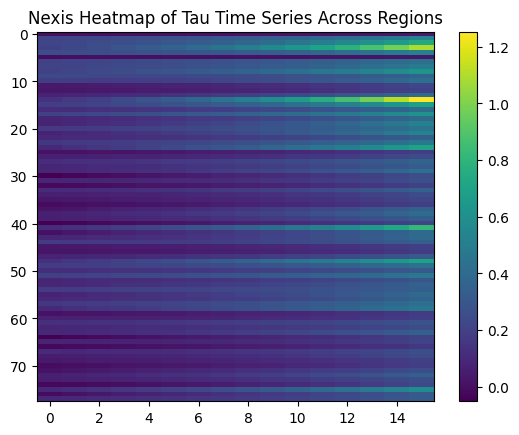

In [120]:
# Parameters for simulate_nexis method
parameters = optimized_params  # (alpha, beta, gamma, b, p, k) 

# Call the simulate_nexis method with the optimized parameters 
if model == 'global':
    Y = nexis_model_global.simulate_nexis(parameters)
else:
    Y = nexis_model_gene.simulate_nexis(parameters)

# Take stages from Y that correspond to patient's stages 
Y_edited = Y[:, stages]

# Plot heatmap of Y
plt = heatmap(init_vec_method, Y)

## Check Results

In [121]:
# Calculate Pearson's correlation coefficient R 
patient_tau_reshaped = patient_tau.reshape(-1)
Y_edited_reshaped = Y_edited.reshape(-1)
R, p_value = pearsonr(patient_tau_reshaped, Y_edited_reshaped)
print("Pearson's R:", R)
print("P-value:", p_value)

# Calculate MSE between EBM data and Y
mse = mse_matrix(patient_tau, Y_edited)
print('Mean squared error: ' + str(mse))

Pearson's R: 0.8993903670356937
P-value: 4.926005277065135e-29
Mean squared error: 0.0049215864549791285


<function matplotlib.pyplot.show(close=None, block=None)>

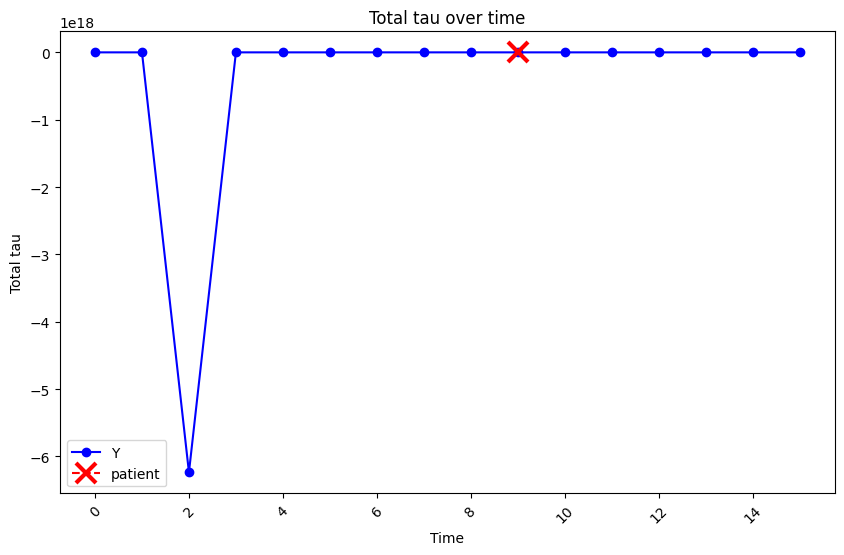

In [60]:
# Plot total tau over time 

# Calculate total tau based on regional volumes and tau density 
regional_volumes_array = np.array(regional_volumes_excluded)
regional_volumes_array = regional_volumes_array.reshape((78,1))
tau_mass_Y = regional_volumes_array * Y 
total_tau_Y = np.sum(tau_mass_Y, axis=0)
tau_mass_patient = regional_volumes_array * patient_tau
total_tau_patient = np.sum(tau_mass_patient, axis=0)

time_points_Y = np.linspace(0, 15, 16)

plt.figure(figsize=(10, 6))

# Plot total_tau_Y
plt.plot(time_points_Y, total_tau_Y, marker='o', linestyle='-', color='b', label= 'Y')  

# Plot total_tau_patient on the same graph
plt.plot(stages, total_tau_patient, marker='x', linestyle='--', color='r', label= 'patient', markersize=15, markeredgewidth=3)
plt.title('Total tau over time') 
plt.xlabel('Time')  # Label the x-axis
plt.ylabel('Total tau')  # Label the y-axis
plt.xticks(rotation=45)  # Optional: rotate x-axis labels for better readability
plt.legend()  # Add a legend to distinguish the two lines

# Show the plot
plt.show

## Loop through all genes and individuals 

In [36]:
# Avoid repeating any RIDS
unique_rids = patient_data['RID'].unique()

# Create a list of all genes
gene_list = gene_data.columns.tolist()

# Create a dictionary of DataFrames for each gene
column_names = ['RID', 'Model', 'R squared', 'alpha', 'beta', 'gamma', 's', 'b', 'p', 'k']
results = {gene: pandas.DataFrame(columns=column_names) for gene in gene_list}

warnings.filterwarnings("ignore", category=ODEintWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Outer loop through RIDs
for rid in unique_rids:
    patient = patient_data[patient_data['RID'] == rid]

    # Define number of time points 
    num_time_points = patient.shape[0]

    # Define list with stage assignments for each time point
    stages = [int(x) for x in patient['ml_stage'].tolist()]

    # Define patient tau data
    patient_tau = patient.iloc[:, 4:].to_numpy().T
    patient_tau_reshaped = patient_tau.reshape(-1)

    # Run Nexis global once per RID
    custom_Nexis_error_global = partial(Nexis_error, patient_tau=patient_tau, stages=stages, nexis_model=nexis_model_global)
    result_global = minimize(custom_Nexis_error_global, init_guess_global, bounds=bounds_global, method='Powell', 
                      options={'ftol': 1e-4, 'xtol': 1e-4})
    
    if result_global.success:
        optimized_params_global = result_global.x.tolist()
        # Run Nexis global with optimized parameters
        Y = nexis_model_global.simulate_nexis(optimized_params_global)
        Y_edited = Y[:, stages]
        # Check if Y_edited is constant
        if np.all(Y_edited == Y_edited[0]):
            Y_edited[0] = Y_edited[0] + 0.00001
        Y_edited_reshaped = Y_edited.reshape(-1)
        R_global, p_value_global = pearsonr(patient_tau_reshaped, Y_edited_reshaped)
        R_squared_global = R_global ** 2
    else:
        optimized_params_global = [np.nan] * 7
        R_squared_global = np.nan

    # Inner loop through genes
    for gene in gene_list:
        gene_data_selected = gene_data[[gene]]
        
        # Run Nexis with gene
        gene_data_array = gene_data_selected.to_numpy()
        gene_data_reordered = gene_data_array[new_order_DK, :]
        gene_data_excluded = np.delete(gene_data_reordered, excluded_indices)
        gene_data_excluded = gene_data_excluded.reshape(78,1)
        U_gene_ = gene_data_excluded
        
        nexis_model_gene = run_Nexis(C_=C_, U_=U_gene_, init_vec_=init_vec_, t_vec_=t_vec_, w_dir_=w_dir_,
                           volcorrect_=volcorrect_, use_baseline_=use_baseline_,
                           region_volumes_=region_volumes_, logistic_term_=logistic_term_, datadir_=datadir_)

        custom_Nexis_error_gene = partial(Nexis_error, patient_tau=patient_tau, stages=stages, nexis_model=nexis_model_gene)
        result_gene = minimize(custom_Nexis_error_gene, init_guess_gene, bounds=bounds_gene, method='Powell', 
                      options={'ftol': 1e-4, 'xtol': 1e-4})

        if result_gene.success:
            optimized_params_gene = result_gene.x.tolist()
            Y = nexis_model_gene.simulate_nexis(optimized_params_gene)
            Y_edited = Y[:, stages]
            if np.all(Y_edited == Y_edited[0]):
                Y_edited[0] = Y_edited[0] + 0.00001

            if np.std(patient_tau) != 0 and np.std(Y_edited) != 0:
                R_gene, p_value_gene = pearsonr(patient_tau.flatten(), Y_edited.flatten())
            else:
                R_gene, p_value_gene = np.nan, np.nan
            R_squared_gene = R_gene ** 2
        else:
            optimized_params_gene = [np.nan] * 7
            R_squared_gene = np.nan

        # Create new rows for both global and gene results
        new_rows = pandas.DataFrame({
            'RID': [rid, rid], 
            'Model': ['Global', 'Gene'],
            'R squared': [R_squared_global, R_squared_gene],
            'alpha': [optimized_params_global[0], optimized_params_gene[0]],
            'beta': [optimized_params_global[1], optimized_params_gene[1]],
            'gamma': [optimized_params_global[2], optimized_params_gene[2]],
            's': [optimized_params_global[3], optimized_params_gene[3]],
            'b': [optimized_params_global[4], optimized_params_gene[4]],
            'p': [optimized_params_global[5], optimized_params_gene[5]],
            'k': [optimized_params_global[6], optimized_params_gene[6]]
        })
        
        new_rows = new_rows.dropna(how='all')
        
        if not new_rows.empty:

            results[gene] = pandas.concat([results[gene], new_rows], ignore_index=True)

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6001165204611D+01   r2 =  0.3793535966880D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6001165204611D+01   r2 =  0.3793535966880D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6001165204611D+01   r2 =  0.3793535966880D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6001165204611D+01   r2 =  0.3793535966880D-15
 lsoda--  warning..internal t (=r1) 

/Users/robinsandell/Desktop/Raj Lab/Human Nexis/CODE Nexis Human/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)


In [19]:
# Create dater frame for results
global_results = []
gene_results = []

for key, df in results.items():
    df_copy = df.copy()
    df_copy['Gene'] = key
    
    # Split into global and gene results
    global_rows = df_copy[df_copy['Model'] == 'Global']
    gene_rows = df_copy[df_copy['Model'] == 'Gene']
    
    # Only keep the first occurrence of global results for each RID
    if len(global_results) == 0:
        global_results.append(global_rows)
    
    gene_results.append(gene_rows)

# Combine results
all_genes = pandas.concat([
    pandas.concat(global_results, ignore_index=True),  # Global results (one per RID)
    pandas.concat(gene_results, ignore_index=True)     # Gene results (all genes)
])

# Reorder columns 
cols = all_genes.columns.tolist()
cols = [cols[-1]] + cols[:-1]
all_genes = all_genes[cols]

,Gene,RID,Model,R squared,alpha,beta,gamma,s,b,p,k
0,ABCA1,6483,Global,0.724509,1.027701e-01,0.117228,1.0,0.999973,0.000000,0.000000,1000.0
0,ABCA1,6483,Gene,0.798517,3.937669e-12,0.083130,1.0,0.999934,0.587532,0.210068,1000.0
1,ABCA7,6483,Gene,0.799027,2.223011e-01,0.115773,1.0,0.999934,0.180974,-0.237741,1000.0
2,ADAM17,6483,Gene,0.739053,1.608881e-02,0.066793,1.0,0.999934,1.895433,0.182997,1000.0
3,ADAMTS1,6483,Gene,0.020737,2.174874e-01,0.116400,1.0,0.999934,-0.112362,2.734857,1000.0
...,...,...,...,...,...,...,...,...,...,...,...
95,ZBTB11,6483,Gene,0.729630,1.235840e-01,0.152518,1.0,1.000000,-0.309704,-0.040264,1000.0
96,ZBTB7A,6483,Gene,0.753653,1.472558e-01,0.116676,1.0,0.999934,0.269532,-0.084922,1000.0
97,ZC3H10,6483,Gene,0.020737,1.040858e-01,0.117372,1.0,0.999934,0.341054,2.708246,1000.0
98,ZCWPW1,6483,Gene,0.020737,1.040858e-01,0.117372,1.0,0.999934,-0.020010,2.708246,1000.0


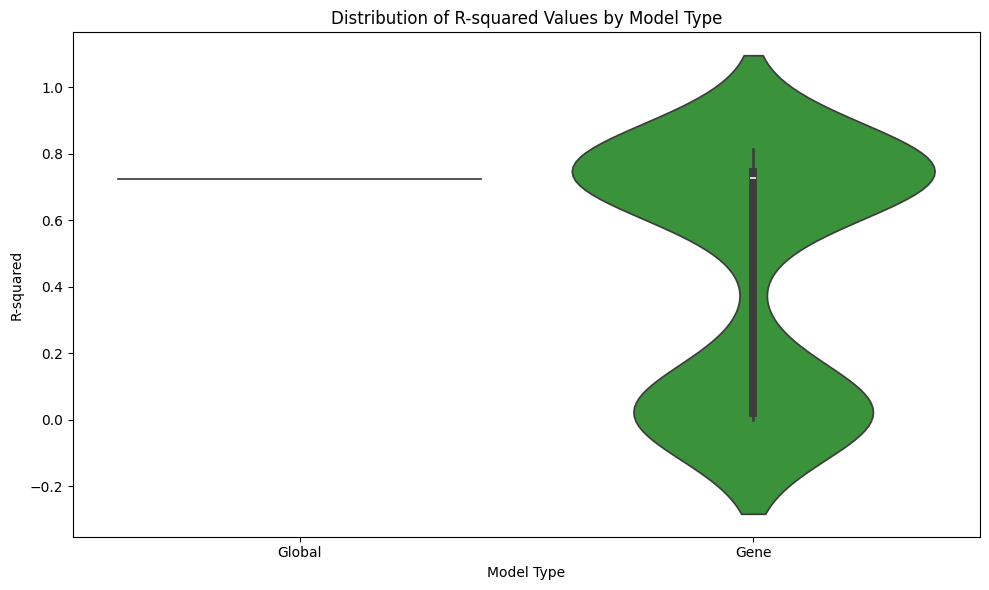

In [61]:
# Plot distribution of R squared values across models 
plt.figure(figsize=(10, 6))

# Create violin plot
sns.violinplot(data=all_genes, x='Model', y='R squared', 
               palette=['#1f77b4', '#2ca02c'])  # Different colors for Global vs Gene

# Customize plot
plt.title('Distribution of R-squared Values by Model Type')
plt.xlabel('Model Type')
plt.ylabel('R-squared')

# Adjust layout and display
plt.tight_layout()
plt.show()


In [ ]:
# Save to csv
filename = 'results.csv'
all_genes.to_csv(filename, index=False)

In [ ]:
# OR save each gene to a seperate csv
for key, df in results.items():
    filename = f"{key}.csv" 
    df.to_csv(filename, index=False)  